# To Do

- **DONE** Fee calculation through time steps
  - Set up time dimension for simulation of accruded fee (see notebook, fee simulation in time steps impacts interest forecasting)
- Minimalise Fee calculation for time steps (reduce to necessary calculations)
- ADD MINIMAL VOLUME CONDITION TO VOLUME CALCULATION
  - volume >= USDt0 - USDtn
- Add mean reverting to the ginven value in tn
  - tn value is another input
  - simulating paths that will eventually end in inputted value tn

- put tn calculation to for cycle at n-amount of cycles
  - calculating values for n-time periods
- clean up GBM for Price and Stoch process for Volume
  - use the only for generating simulations
  - parameter estimation to be done in separate .ipynb

- **DONE** correct FX calculation
- **DONE** make engine with FX input

# Libraries

In [153]:
#%%

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import statistics

import time
import datetime

# Datasets

In [154]:
# %%

# Reserves dataframe

pool_reserves = pd.DataFrame(
    columns=['k', 'amount_USD', 'amount_y', 'value_in_USD', 'USD_fee', 'y_fee']
    )

depositor_reserves = pd.DataFrame(
    columns=['k', 'amount_USD', 'amount_y', 'value_in_USD', 'USD_fee', 'y_fee']
    )

# Unique Features dataframe

depositor_performance = pd.DataFrame(
    columns=['pool_share', 'interest_income', 'hodl_USD', 'impermanent_loss', 'IL_rel', 'II_netto'] #interest_income is relative
)

pool_performance = pd.DataFrame(
    columns=['FX', 'pool_fee', 'volume']
)


In [155]:
# Datasets 2.0

# Reserves dataframe

pool_reserves = pd.DataFrame(
    columns=['k', 'amount_USD', 'amount_y', 'value_in_USD', 'USD_fee', 'y_fee']
    )

depositor_reserves = pd.DataFrame(
    columns=['k', 'amount_USD', 'amount_y', 'value_in_USD', 'USD_fee', 'y_fee']
    )

# Unique Features dataframe

depositor_performance = pd.DataFrame(
    columns=['pool_share', 'interest_income', 'hodl_USD', 'impermanent_loss', 'IL_rel', 'II_netto']
)

pool_performance = pd.DataFrame(
    columns=['FX', 'pool_fee', 'volume']
)

# Parameters

In [156]:
# %%
# Depositor inputs
total_investment_USD = 200

# Depositor parameters
deposit_split_percentage = 0.5

# Pool inputs
amount_USD_pool_t0 = 900
amount_y_pool_t0 = 9

# Pool parameters
pool_fee = 0.01
fee_split_percentage = 0.5

# Traffic inputs
volume_amount_t0 = {
    'USD' : 0,
    'y' : 0
}

"""# Stochastic volume value in tn
volume_in_x = 546.9181606780271

# Stochastic price value in tn
FX_tn = 239.29558"""

'# Stochastic volume value in tn\nvolume_in_x = 546.9181606780271\n\n# Stochastic price value in tn\nFX_tn = 239.29558'

# User defined functions

## Fundamental Functions

In [157]:
# %%
# calculation functions

def k_product(x, y):
    return(x*y)

def value_in_x(x, y, FX):
    return(x + y * FX)

def FX_x_over_y(k_pool, y_amount):
    return(k_pool / (y_amount**2))

def deposit_split(deposit_value_in_x, percentage_of_x, FX_x_over_y):
    x_amount = deposit_value_in_x * percentage_of_x
    y_amount = (deposit_value_in_x - x_amount) / FX_x_over_y
    return x_amount, y_amount

def pool_share(k_depositor, k_pool):
    return (math.sqrt(k_depositor)/math.sqrt(k_pool))

def interest_income(accruded_fee_in_x, value_in_x, relative = 'N'):
    return accruded_fee_in_x/value_in_x

def hold_in_x(amount_x_t0, amount_y_t0, FX_tn):
    return amount_x_t0 + amount_y_t0 * FX_tn

def impermanent_loss(FX_in_x_t0, FX_in_x_tn, relative = 'N'):
    if relative == 'N':
        result = value_in_x - hodl_in_x
    else:
        result = ((2*math.sqrt(FX_in_x_tn/FX_in_x_t0))/(1+(FX_in_x_tn/FX_in_x_t0)))-1
    return result

def fee_amount_by_orders(volume_amount_in_origin, fee_rate, fee_split): 
    x_fee_amount = list(volume_amount_in_origin.values())[0] * fee_rate
    y_fee_amount = list(volume_amount_in_origin.values())[1] * fee_rate
    return x_fee_amount, y_fee_amount

def swap_calc(quote_type, swap_from_amount_reserve , swap_to_amount_reserve): #TODO zkontrolovat zda sedi s algo v DP

    usd = swap_from_amount_reserve[2]
    y = swap_to_amount_reserve[2]

    k = k_product(usd, y)

    if quote_type == 'ask':
        y_ask = swap_to_amount_reserve[1]
        usd_for_ask = ((k*(y-y_ask))/((y-y_ask)**2))-usd
        result = usd_for_ask
    elif quote_type == 'bid':
        usd_bid = swap_from_amount_reserve[1]
        y_for_bid = y-((k*(usd+usd_bid))/((usd+usd_bid)**2))
        result = y_for_bid
    else:
      print('inproper operation')

    return result

def fee_amount_by_reserves(FX_in_x, volume_in_x, fee_rate):

    y_amount_exchanged = volume_in_x / FX_in_x
    y_fee_amount = y_amount_exchanged / 2 * fee_rate
    x_fee_amount = volume_in_x / 2 * fee_rate

    return x_fee_amount, y_fee_amount

def reserves_calc(k, FX_in_x, calculate_x = True):
    if calculate_x == True:
      x_amount = (k * FX_in_x)**(1/2)
      result = x_amount
    elif calculate_x == False:
      y_amount = (k / FX_in_x)**(1/2)
      result = y_amount
    else:
      print('Wrong input in "calculate_x" parameter')

    return result

# FX rates analysis

In [158]:
class price_sim:

  def data_loading(self, ticker, start_date, end_date, interval):

    self.ticker = ticker
    self.start_date = start_date
    self.end_date = end_date
    self.interval = interval

    yh_start_date = int(time.mktime(datetime.datetime(self.start_date[0], self.start_date[1], self.start_date[2], 23, 59).timetuple()))

    if self.end_date == 'today':
      yh_end_date = int(time.mktime(datetime.datetime.now().timetuple()))
    else:
      yh_end_date = int(time.mktime(datetime.datetime(self.end_date[0], self.end_date[1], self.end_date[2], 23, 59).timetuple()))

    query_string1 = f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={yh_start_date}&period2={yh_end_date}&interval={self.interval}&events=history&includeAdjustedClose=true'

    FX_data = pd.read_csv(query_string1)

    return FX_data

  def returnify(self, FX_data, date_col = None):

      self.FX_data = FX_data
      self.date_col = date_col

      if self.date_col != None:
        prices = self.FX_data.loc[:, self.FX_data.columns != self.date_col]
        dates = self.FX_data[date_col]
        returns = prices / prices.shift(1) - 1
        returnified = pd.concat([dates, returns], axis = 1,)

      else:
        prices = self.FX_data
        returns = prices / prices.shift(1) - 1
        returnified = returns

      return returnified

  def log_returnify(self, FX_data, date_col = None):

      self.FX_data = FX_data
      self.date_col = date_col

      if self.date_col != None:
        prices = self.FX_data.loc[:, self.FX_data.columns != self.date_col]
        dates = self.FX_data[self.date_col]
        returns = np.log(prices) - np.log(prices.shift(1))
        returnified = pd.concat([dates, returns], axis = 1,)

      else:
        prices = self.FX_data
        returns = np.log(prices) - np.log(prices.shift(1))
        returnified = returns

      return returnified

  def GBM_params(self, returns):

      self.returns = returns

      mu = self.returns.describe().at['mean']
      sigma = self.returns.describe().at['std']

      return mu, sigma

  def GBM(self, mu, sigma, S0, steps, n_paths, plot = 'N', pandas = 'Y'):

      self.mu = mu
      self.sigma = sigma
      self.S0 = S0
      self.steps = steps
      self.n_paths = n_paths
      self.plot = plot
      self.pandas = pandas

      T = 1

      # calc each time step
      dt = T/self.steps

      # simulation using numpy arrays
      St = np.exp(
          (self.mu - self.sigma ** 2 / 2) * dt
          + self.sigma * np.random.normal(0, np.sqrt(dt), size=(self.n_paths,self.steps)).T
      )

      # include array of 1's
      St = np.vstack([np.ones(self.n_paths), St])

      # multiply through by S0 and return the cumulative product of elements along a given simulation path (axis=0).
      St = self.S0 * St.cumprod(axis=0)

      if self.plot == 'Y':
        # Define time interval correctly
        time = np.linspace(0,T,self.steps+1)

        # Require numpy array that is the same shape as St
        tt = np.full(shape=(self.n_paths,self.steps+1), fill_value=time).T

        plt.plot(tt, St)
        plt.xlabel("Years $(t)$")
        plt.ylabel("Stock Price $(S_t)$")
        plt.title(
            "Realizations of Geometric Brownian Motion\n $dS_t = \mu S_t dt + \sigma S_t dW_t$\n $S_0 = {0}, \mu = {1}, \sigma = {2}$".format(self.S0, self.mu, self.sigma)
        )
        plt.show()

      if self.pandas == 'Y':
        output_St = pd.DataFrame(St)
      else:
        output_St = St

      return output_St

  def plot_paths(self, sim_df, FX_df, predicted_period, backtesting = False):

    self.sim_df = sim_df
    self.FX_df = FX_df
    self.predicted_period = predicted_period
    self.backtesting = backtesting

    time_space = np.linspace(0,1,self.predicted_period+1)
    tt = np.full(shape=(10000, self.predicted_period + 1), fill_value=time_space).T
    tt_fx = np.full(shape=(1, self.predicted_period + 1), fill_value=time_space).T

    temp = self.FX_df[self.FX_df.index >= len(self.FX_df)-self.predicted_period-1].reset_index(drop = True)

    if self.backtesting == True:
      plot_df = self.sim_df
    else:
      df_nan = pd.DataFrame(np.nan, index=range(self.predicted_period), columns=range(len(self.sim_df.columns)))
      plot_df = pd.concat([df_nan, self.sim_df]).reset_index(drop = True)
      temp = pd.concat([temp, df_nan]).reset_index(drop = True)
      time_space = np.linspace(0,1,2*self.predicted_period+1)
      tt = np.full(shape=(10000, 2*self.predicted_period + 1), fill_value=time_space).T
      tt_fx = np.full(shape=(1, 2*self.predicted_period + 1), fill_value=time_space).T

    fig = plt.figure(figsize=(8,5))
    plt.plot(tt, plot_df)
    plt.plot(tt_fx, temp, linewidth = 3, c = 'k')
    plt.xlabel("Years $(t)$")
    plt.ylabel("Exchange Rate $(S_t)$")
    plt.title(
            "Realizations of Geometric Brownian Motion of {3}\n $dS_t = \mu S_t dt + \sigma S_t dW_t$\n $S_0 = {0}, \mu = {1}, \sigma = {2}$".format(round(self.S0,6), round(self.mu,6), round(self.sigma,6), self.ticker)
        )
    plt.grid()
    plt.show()

  def pipeline(self, ticker, start_date, end_date, interval, predicted_period, backtesting):

    self.ticker = ticker
    self.start_date = start_date
    self.end_date = end_date
    self.interval = interval
    self.predicted_period = predicted_period
    self.backtesting = backtesting

    self.FX_data = self.data_loading(ticker = self.ticker,
                              start_date=self.start_date,
                              end_date=self.end_date,
                              interval=self.interval)

    self.returns = self.log_returnify(FX_data = self.FX_data,
                            date_col = 'Date')

    self.mu, self.sigma = self.GBM_params(self.returns['Adj Close'])

    self.sim = self.GBM(
        mu = self.mu*(self.predicted_period**(1/2)),
        sigma = self.sigma*(self.predicted_period**(1/2)),
        S0 = self.FX_data.at[len(self.FX_data)-self.predicted_period-1, 'Adj Close'] if backtesting == True else self.FX_data.at[len(self.FX_data)-1, 'Adj Close'],
        #FX_data.at[len(FX_data)-predicted_period-1, 'Close'],
        steps = self.predicted_period,
        n_paths = 10000)

    self.plot_paths(
        sim_df = self.sim,
        FX_df = self.FX_data['Adj Close'],
        predicted_period = self.predicted_period,
        backtesting = self.backtesting)



## USDEUR

In final code this will be just loading simulations from saved file that was generatedin GBM.ipynb

/Users/danielmalinovsky/opt/anaconda3/envs/vseML/lib/python3.9/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


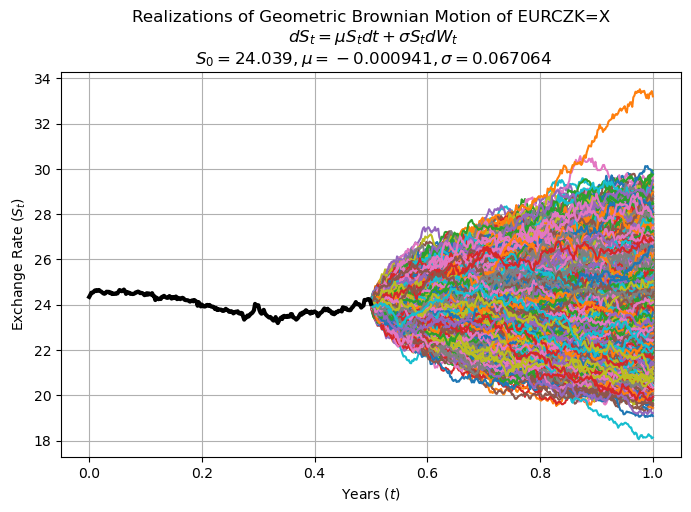

In [159]:
EURUSD_price = price_sim()

EURUSD_price.pipeline(ticker = 'EURCZK=X',
                    start_date=[2020,1,1],
                    end_date='today',
                    interval='1d',
                    predicted_period = 260,
                    backtesting = False)

# Volume Analysis

In [160]:
class volume_sim:

  def returnify(self, FX_data, date_col = None):

      self.FX_data = FX_data
      self.date_col = date_col

      if self.date_col != None:
        prices = self.FX_data.loc[:, self.FX_data.columns != self.date_col]
        dates = self.FX_data[date_col]
        returns = prices / prices.shift(1) - 1
        returnified = pd.concat([dates, returns], axis = 1,)

      else:
        prices = self.FX_data
        returns = prices / prices.shift(1) - 1
        returnified = returns

      return returnified

  def log_returnify(self, FX_data, date_col = None):

      self.FX_data = FX_data
      self.date_col = date_col

      if self.date_col != None:
        prices = self.FX_data.loc[:, self.FX_data.columns != self.date_col]
        dates = self.FX_data[self.date_col]
        returns = np.log(prices) - np.log(prices.shift(1))
        returnified = pd.concat([dates, returns], axis = 1,)

      else:
        prices = self.FX_data
        returns = np.log(prices) - np.log(prices.shift(1))
        returnified = returns

      return returnified

  def GBM_params(self, returns):

      self.returns = returns

      mu = self.returns.describe().at['mean']
      sigma = self.returns.describe().at['std']

      return mu, sigma

  def GBM(self, mu, sigma, S0, steps, n_paths, plot = 'N', pandas = 'Y'):

      self.mu = mu
      self.sigma = sigma
      self.S0 = S0
      self.steps = steps
      self.n_paths = n_paths
      self.plot = plot
      self.pandas = pandas

      T = 1

      # calc each time step
      dt = T/self.steps

      # simulation using numpy arrays
      St = np.exp(
          (self.mu - self.sigma ** 2 / 2) * dt
          + self.sigma * np.random.normal(0, np.sqrt(dt), size=(self.n_paths,self.steps)).T
      )

      # include array of 1's
      St = np.vstack([np.ones(self.n_paths), St])

      # multiply through by S0 and return the cumulative product of elements along a given simulation path (axis=0).
      St = self.S0 * St.cumprod(axis=0)

      if self.plot == 'Y':
        # Define time interval correctly
        time = np.linspace(0,T,self.steps+1)

        # Require numpy array that is the same shape as St
        tt = np.full(shape=(self.n_paths,self.steps+1), fill_value=time).T

        plt.plot(tt, St)
        plt.xlabel("Years $(t)$")
        plt.ylabel("Stock Price $(S_t)$")
        plt.title(
            "Realizations of Geometric Brownian Motion\n $dS_t = \mu S_t dt + \sigma S_t dW_t$\n $S_0 = {0}, \mu = {1}, \sigma = {2}$".format(self.S0, self.mu, self.sigma)
        )
        plt.show()

      if self.pandas == 'Y':
        output_St = pd.DataFrame(St)
      else:
        output_St = St

      return output_St

  def UOP(self, mu, sigma, theta, S0, steps, n_paths, plot = 'N', pandas = 'Y'):
  # Set the parameters of the Ornstein-Uhlenbeck process

    self.mu = mu
    self.sigma = sigma
    self.theta = theta
    self.S0 = S0
    self.steps = steps
    self.n_paths = n_paths
    self.plot = plot
    self.pandas = pandas

    T = 1

    # calc each time step
    dt = T/steps

    # Create an array to store the paths
    paths = np.zeros((self.n_paths, self.steps+1))
    paths[:,0] = self.S0

    # Generate the paths
    for i in range(self.steps):
        dw = np.random.normal(scale=np.sqrt(dt), size=self.n_paths)
        paths[:,i+1] = paths[:,i] + self.theta*(mu-paths[:,i])*dt + self.sigma*dw

    # Plot the paths
    if self.plot == 'Y':
      time_steps = np.linspace(0, T, self.steps+1)
      for i in range(self.n_paths):
          plt.plot(time_steps, paths[i])
      plt.xlabel('Time')
      plt.ylabel('Value')
      plt.title('Ornstein-Uhlenbeck Process with Multiple Paths')
      plt.show()

    if self.pandas == 'Y':
      output_St = pd.DataFrame(paths).transpose()
    else:
      output_St = paths.transpose()

    return output_St

  def plot_paths(self, sim_df, FX_df, predicted_period, backtesting = False):

    self.sim_df = sim_df
    self.FX_df = FX_df
    self.predicted_period = predicted_period
    self.backtesting = backtesting

    time_space = np.linspace(0,1,self.predicted_period+1)
    tt = np.full(shape=(10000, self.predicted_period + 1), fill_value=time_space).T
    tt_fx = np.full(shape=(1, self.predicted_period + 1), fill_value=time_space).T

    temp = self.FX_df[self.FX_df.index >= len(self.FX_df)-self.predicted_period-1].reset_index(drop = True)

    if self.backtesting == True:
      plot_df = self.sim_df
    else:
      df_nan = pd.DataFrame(np.nan, index=range(self.predicted_period), columns=range(len(self.sim_df.columns)))
      plot_df = pd.concat([df_nan, self.sim_df]).reset_index(drop = True)
      temp = pd.concat([temp, df_nan]).reset_index(drop = True)
      time_space = np.linspace(0,1,2*self.predicted_period+1)
      tt = np.full(shape=(10000, 2*self.predicted_period + 1), fill_value=time_space).T
      tt_fx = np.full(shape=(1, 2*self.predicted_period + 1), fill_value=time_space).T

    fig = plt.figure(figsize=(8,5))
    plt.plot(tt, plot_df)
    plt.plot(tt_fx, temp, linewidth = 3, c = 'k')
    plt.xlabel("Years $(t)$")
    plt.ylabel("Exchange Volume $(V_t)$")
    plt.title(
            "Realizations of Ornstein-Uhlenbeck Process of {3}\n $dV_t = \\theta (\mu - V_t) dt + \sigma dW_t$ \n $S_0 = {0}, \\theta = {4}, \mu = {1}, \sigma = {2}$".format(round(self.S0,0), round(self.mu,0), round(self.sigma,0), self.ticker, round(self.theta,6))
    )
    plt.grid()
    plt.show()

  def pipeline(self, ticker, volume, predicted_period, backtesting):

    self.ticker = ticker
    #self.start_date = start_date
    #self.end_date = end_date
    #self.interval = interval
    self.predicted_period = predicted_period
    self.backtesting = backtesting
    self.FX_data = volume

    """
    self.FX_data = self.data_loading(ticker = self.ticker,
                              start_date=self.start_date,
                              end_date=self.end_date,
                              interval=self.interval)

    self.returns = self.log_returnify(FX_data = self.FX_data,)
                            #date_col = 'Date')
    """
    self.mu, self.sigma = self.GBM_params(self.FX_data)#.loc[len(self.FX_data) - predicted_period:])

    self.sim = self.UOP(
        mu = self.mu,
        sigma = self.sigma,#*(self.predicted_period**(1/2)),
        theta = 5,
        S0 = self.FX_data.at[len(self.FX_data)-self.predicted_period-1] if backtesting == True else self.FX_data.at[len(self.FX_data)-1],
        #FX_data.at[len(FX_data)-predicted_period-1, 'Close'],
        steps = self.predicted_period,
        n_paths = 10000)

    self.plot_paths(
        sim_df = self.sim,
        FX_df = self.FX_data,
        predicted_period = self.predicted_period,
        backtesting = self.backtesting)



## USDEUR

Volume data preparation

In [161]:
raw_data = pd.read_csv("./^eurczk_price-history-08-11-2023.csv", index_col = False)

volume_data = raw_data['Volume']

mu = volume_data.describe().at['mean']
sigma = volume_data.describe().at['std']

volume_data_no_outlier = volume_data.copy()
volume_data_no_outlier = volume_data_no_outlier[(volume_data_no_outlier < mu+3*sigma) & (volume_data_no_outlier > mu-3*sigma)].reset_index(drop = True)
volume_data_no_outlier

0      11297.0
1      27271.0
2      25850.0
3      28301.0
4      25349.0
        ...   
513    21741.0
514    21816.0
515    24879.0
516    22328.0
517    22911.0
Name: Volume, Length: 518, dtype: float64

In [162]:
EURUSD_volume = volume_sim()

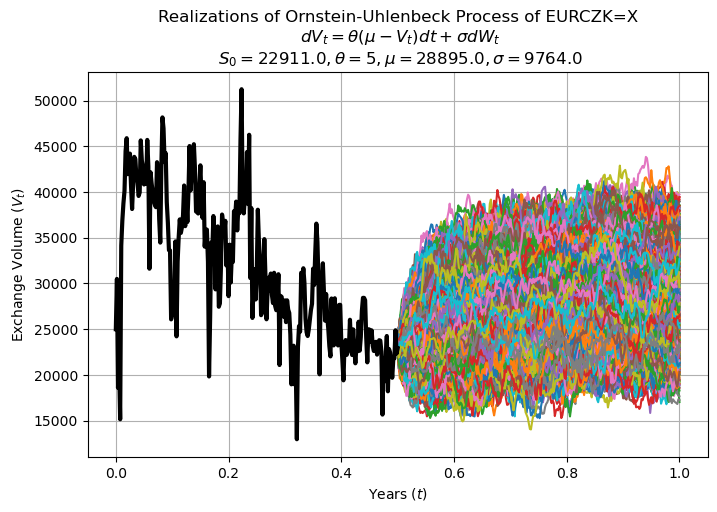

In [163]:
EURUSD_volume.pipeline(ticker = 'EURCZK=X',
                    volume = volume_data_no_outlier,
                    predicted_period = 260,
                    backtesting = False)

# Engines with time dimension

## Calculation: Stoch FX level

### t0 state

# %%
# t0 pre - calculation
pool_performance.at[0, 'pool_fee'] = pool_fee
pool_reserves.at[0, 'k'] = k_product(amount_USD_pool_t0, amount_y_pool_t0)
pool_performance.at[0, 'FX'] = FX_x_over_y(pool_reserves.at[0, 'k'], amount_y_pool_t0)

# t0 deposit calculation
depositor_reserves.at[0, 'value_in_USD'] = total_investment_USD
depositor_reserves.at[0, 'amount_USD'], depositor_reserves.at[0, 'amount_y'] = deposit_split(total_investment_USD, deposit_split_percentage, pool_performance.at[0, 'FX'])
depositor_reserves.at[0, 'k'] = k_product(depositor_reserves.at[0, 'amount_USD'], depositor_reserves.at[0, 'amount_y'])

# t0 pool calculation

pool_reserves.at[0, 'amount_USD'] = amount_USD_pool_t0 + depositor_reserves.at[0, 'amount_USD']
pool_reserves.at[0, 'amount_y'] = amount_y_pool_t0 + depositor_reserves.at[0, 'amount_y']
pool_reserves.at[0, 'k'] = k_product(pool_reserves.at[0, 'amount_USD'], pool_reserves.at[0, 'amount_y'])
pool_reserves.at[0, 'value_in_USD'] = value_in_x(pool_reserves.at[0, 'amount_USD'], pool_reserves.at[0, 'amount_y'], pool_performance.at[0, 'FX'])

# t0 change calculation
pool_performance.at[0, 'FX'] = FX_x_over_y(pool_reserves.at[0, 'k'], pool_reserves.at[0, 'amount_y'])

temp_fee_amount = fee_amount_by_orders(volume_amount_t0, pool_fee, fee_split_percentage)
pool_reserves.at[0, 'USD_fee'] = temp_fee_amount[0]
pool_reserves.at[0, 'y_fee'] = temp_fee_amount[1]

depositor_performance.at[0, 'pool_share'] = pool_share(depositor_reserves.at[0, 'k'], pool_reserves.at[0, 'k'])
depositor_reserves.at[0, 'USD_fee'] = pool_reserves.at[0, 'USD_fee'] * depositor_performance.at[0, 'pool_share']
depositor_reserves.at[0, 'y_fee'] = pool_reserves.at[0, 'y_fee'] * depositor_performance.at[0, 'pool_share']

depositor_performance.at[0, 'interest_income'] = interest_income(
    value_in_x(
        depositor_reserves.at[0, 'USD_fee'],
        depositor_reserves.at[0, 'y_fee'],
        pool_performance.at[0, 'FX']
        ),
    depositor_reserves.at[0, 'value_in_USD']
    )
depositor_performance.at[0, 'hodl_USD'] = hold_in_x(
    depositor_reserves.at[0, 'amount_USD'],
    depositor_reserves.at[0, 'amount_y'],
    pool_performance['FX'][0]
    )
"""depositor_performance.at[0, 'impermanent_loss'] = impermanent_loss(
    depositor_performance.at[0, 'hodl_USD'],
    depositor_reserves.at[0, 'value_in_USD'],
    relative='N'
    )"""
depositor_performance.at[0, 'IL_rel'] = impermanent_loss(
    depositor_performance.at[0, 'hodl_USD'],
    depositor_reserves.at[0, 'value_in_USD'],
    relative='Y'
    )

### tn state

In [164]:
i = 1

# %%
# tn pre - calculation
# pool
pool_performance.at[i, 'pool_fee'] = pool_performance.at[i-1, 'pool_fee']
pool_performance.at[i, 'FX'] = FX_tn ####################### Stoch FX input

#temp_fee_amount = fee_amount(volume_amount_tn, pool_fee, fee_split_percentage)

pool_reserves.at[i, 'amount_USD'] = reserves_calc(pool_reserves.at[i-1, 'k'], pool_performance.at[i, 'FX'], calculate_x= True) #- pool_tn.at['pool', 'accruded_fee']['USD'] ####### change here transaction costs
pool_reserves.at[i, 'amount_y'] = reserves_calc(pool_reserves.at[i-1, 'k'], pool_performance.at[i, 'FX'], calculate_x= False) #- pool_tn.at['pool', 'accruded_fee']['y'] ####### change here transaction costs
pool_reserves.at[i, 'k'] = k_product(pool_reserves.at[i, 'amount_USD'], pool_reserves.at[i, 'amount_y'])

temp_fee_amount = fee_amount_by_reserves(
    (pool_performance.at[i, 'FX'] + pool_performance.at[i-1, 'FX'])/2,
    volume_in_x,
    pool_performance.at[i, 'pool_fee']
    )
pool_reserves.at[i, 'USD_fee'] = abs(temp_fee_amount[0])
pool_reserves.at[i, 'y_fee'] = abs(temp_fee_amount[1])
pool_reserves.at[i, 'value_in_USD'] = value_in_x(pool_reserves.at[i, 'amount_USD'], pool_reserves.at[i, 'amount_y'], pool_performance.at[i, 'FX'])

# depositor
depositor_performance.at[i, 'pool_share'] = depositor_performance.at[i-1, 'pool_share']

depositor_reserves.loc[i, ['amount_USD', 'amount_y', 'value_in_USD']] = pool_reserves.loc[i, ['amount_USD', 'amount_y', 'value_in_USD']].values * depositor_performance.at[i, 'pool_share']
depositor_reserves.at[i, 'k'] = k_product(depositor_reserves.at[i, 'amount_USD'], depositor_reserves.at[i, 'amount_y'])

depositor_reserves.at[i, 'USD_fee'] = pool_reserves.at[i, 'USD_fee'] * depositor_performance.at[i, 'pool_share']
depositor_reserves.at[i, 'y_fee'] = pool_reserves.at[i, 'y_fee'] * depositor_performance.at[i, 'pool_share']

depositor_performance.at[i, 'interest_income'] = interest_income(  ####################################### !!!!! Interest Income is in %
    value_in_x(
        depositor_reserves.at[i, 'USD_fee'],
        depositor_reserves.at[i, 'y_fee'],
        pool_performance.at[i, 'FX']
        ),
    depositor_reserves.at[i, 'value_in_USD']
    )
depositor_performance.at[i, 'hodl_USD'] = hold_in_x(
    depositor_reserves.at[i-1, 'amount_USD'],
    depositor_reserves.at[i-1, 'amount_y'],
    pool_performance.at[i,'FX']
    )
"""depositor_performance.at[i, 'impermanent_loss'] = impermanent_loss(
    depositor_performance.at[i, 'hodl_USD'],
    depositor_reserves.at[i, 'value_in_USD'],
    relative='N'
    )"""
depositor_performance.at[i, 'IL_rel'] = impermanent_loss(
    depositor_performance.at[i, 'hodl_USD'],
    depositor_reserves.at[i, 'value_in_USD'],
    relative='Y'
    )



#pool_tn.at['pool', 'value_in_USD'] = value_in_x(pool_tn.at['pool', 'amount_USD'], pool_tn.at['pool', 'amount_y'], pool_performance_t0.at[0, 'FX'])


pool_reserves

depositor_reserves

pool_performance

depositor_performance

# Simulation

In [245]:
analyzed_periods = 260
captured_volume = 1


FX_t0 = EURUSD_price.FX_data['Adj Close'].iloc[-1]

In [246]:
# %%
# Depositor inputs
total_investment_USD = 20000

# Depositor parameters
deposit_split_percentage = 0.5

# Pool inputs
amount_USD_pool_t0 = 90000
amount_y_pool_t0 = amount_USD_pool_t0/FX_t0

# Pool parameters
pool_fee = 0.01
fee_split_percentage = 0.5

# Stochastic volume value in tn
#volume_in_x = EURUSD_volume.FX_data.iloc[-analyzed_periods:].reset_index(drop = True)*0.01

# Stochastic price value in tn
#FX_tn = EURUSD_price.FX_data['Adj Close'].iloc[-analyzed_periods:].reset_index(drop = True)

### t0 state

In [247]:
pool_performance.at[0, 'pool_fee'] = pool_fee
pool_reserves.at[0, 'k'] = k_product(amount_USD_pool_t0, amount_y_pool_t0)
FX_x_over_y(pool_reserves.at[0, 'k'], amount_y_pool_t0)

24.039

In [248]:
FX_x_over_y(pool_reserves.at[0, 'k'], amount_y_pool_t0)

24.039

In [249]:
# %%
# t0 pool pre - calculation
pool_performance.at[0, 'pool_fee'] = pool_fee
pool_reserves.at[0, 'k'] = k_product(amount_USD_pool_t0, amount_y_pool_t0)
pool_performance.at[0, 'FX'] = FX_x_over_y(pool_reserves.at[0, 'k'], amount_y_pool_t0)

# t0 depositor pre - calculation
### deposit calculation
depositor_reserves.at[0, 'value_in_USD'] = total_investment_USD
depositor_reserves.at[0, 'amount_USD'], depositor_reserves.at[0, 'amount_y'] = deposit_split(total_investment_USD, deposit_split_percentage, pool_performance.at[0, 'FX'])
depositor_reserves.at[0, 'k'] = k_product(depositor_reserves.at[0, 'amount_USD'], depositor_reserves.at[0, 'amount_y'])




# t0 pool calculation

pool_reserves.at[0, 'amount_USD'] = amount_USD_pool_t0 + depositor_reserves.at[0, 'amount_USD']
pool_reserves.at[0, 'amount_y'] = amount_y_pool_t0 + depositor_reserves.at[0, 'amount_y']
pool_reserves.at[0, 'k'] = k_product(pool_reserves.at[0, 'amount_USD'], pool_reserves.at[0, 'amount_y'])
pool_reserves.at[0, 'value_in_USD'] = value_in_x(pool_reserves.at[0, 'amount_USD'], pool_reserves.at[0, 'amount_y'], pool_performance.at[0, 'FX'])

# t0 change calculation
pool_performance.at[0, 'FX'] = FX_x_over_y(pool_reserves.at[0, 'k'], pool_reserves.at[0, 'amount_y'])

temp_fee_amount = fee_amount_by_orders(volume_amount_t0, pool_fee, fee_split_percentage)
pool_reserves.at[0, 'USD_fee'] = temp_fee_amount[0]
pool_reserves.at[0, 'y_fee'] = temp_fee_amount[1]

depositor_performance.at[0, 'pool_share'] = pool_share(depositor_reserves.at[0, 'k'], pool_reserves.at[0, 'k'])
depositor_reserves.at[0, 'USD_fee'] = pool_reserves.at[0, 'USD_fee'] * depositor_performance.at[0, 'pool_share']
depositor_reserves.at[0, 'y_fee'] = pool_reserves.at[0, 'y_fee'] * depositor_performance.at[0, 'pool_share']

depositor_performance.at[0, 'interest_income'] = interest_income(
    value_in_x(
        depositor_reserves.at[0, 'USD_fee'],
        depositor_reserves.at[0, 'y_fee'],
        pool_performance.at[0, 'FX']
        ),
    depositor_reserves.at[0, 'value_in_USD']
    )

depositor_performance.at[0, 'IL_rel'] = impermanent_loss(
    pool_performance.at[0, 'FX'],
    pool_performance.at[0, 'FX'],
    relative='Y'
    )

depositor_performance.at[i, 'II_netto'] = depositor_performance.at[0, 'interest_income'] - depositor_performance.at[0, 'IL_rel']

depositor_performance.at[0, 'hodl_USD'] = hold_in_x(
    depositor_reserves.at[0, 'amount_USD'],
    depositor_reserves.at[0, 'amount_y'],
    pool_performance['FX'][0]
    )
"""depositor_performance.at[0, 'impermanent_loss'] = impermanent_loss(
    depositor_performance.at[0, 'hodl_USD'],
    depositor_reserves.at[0, 'value_in_USD'],
    relative='N'
    )"""


"depositor_performance.at[0, 'impermanent_loss'] = impermanent_loss(\n    depositor_performance.at[0, 'hodl_USD'],\n    depositor_reserves.at[0, 'value_in_USD'],\n    relative='N'\n    )"

### tn state

In [250]:
def progress_bar(current, total, bar_length=20):
    fraction = current / total

    arrow = int(fraction * bar_length - 1) * '-' + '>'
    padding = int(bar_length - len(arrow)) * ' '

    ending = '\n' if current == total else '\r'

    print(f'Progress: [{arrow}{padding}] {int(fraction*100)}%', end=ending)

In [251]:
from IPython.display import clear_output

In [252]:
paths_df = pd.DataFrame()
max_paths = 1000

In [253]:
for j in range(1,max_paths):
#for j in range(1, len(EURUSD_volume.sim_df.iloc[i,:])):

  for i in range(1, len(EURUSD_volume.sim_df.iloc[:,j])):


    # %%
    # tn pre - calculation
    pool_performance.at[i, 'pool_fee'] = pool_performance.at[i-1, 'pool_fee']
    pool_performance.at[i, 'FX'] = EURUSD_price.sim_df.iloc[i, j] ####################### Stoch FX input
    pool_performance.at[i, 'volume'] = EURUSD_volume.sim_df.iloc[i, j]*captured_volume

    #temp_fee_amount = fee_amount(volume_amount_tn, pool_fee, fee_split_percentage)



    #tn pool calculation
    ### reservers
    pool_reserves.at[i, 'amount_USD'] = reserves_calc(pool_reserves.at[i-1, 'k'], pool_performance.at[i, 'FX'], calculate_x= True) #- pool_tn.at['pool', 'accruded_fee']['USD'] ####### change here transaction costs
    pool_reserves.at[i, 'amount_y'] = reserves_calc(pool_reserves.at[i-1, 'k'], pool_performance.at[i, 'FX'], calculate_x= False) #- pool_tn.at['pool', 'accruded_fee']['y'] ####### change here transaction costs
    
    ### fees in x, fees in y
    temp_fee_amount = fee_amount_by_reserves(
        #(pool_performance.at[i, 'FX'] + pool_performance.at[i-1, 'FX'])/2, fee reserves using average FX in between two days
        pool_performance.at[i, 'FX'],
        pool_performance.at[i, 'volume'],
        pool_performance.at[i, 'pool_fee']
        )
    pool_reserves.at[i, 'USD_fee'] = abs(temp_fee_amount[0])
    pool_reserves.at[i, 'y_fee'] = abs(temp_fee_amount[1])

    ### updating reserves,k  with collected fees
    pool_reserves.at[i, 'amount_USD'] = pool_reserves.at[i, 'amount_USD'] + pool_reserves.at[i, 'USD_fee']
    pool_reserves.at[i, 'amount_y'] = pool_reserves.at[i, 'amount_y'] + pool_reserves.at[i, 'y_fee']
    pool_reserves.at[i, 'k'] = k_product(pool_reserves.at[i, 'amount_USD'], pool_reserves.at[i, 'amount_y'])

    ### pool value in x
    pool_reserves.at[i, 'value_in_USD'] = value_in_x(pool_reserves.at[i, 'amount_USD'], pool_reserves.at[i, 'amount_y'], pool_performance.at[i, 'FX'])



    #tn depositor calculation
    ### pool share
    depositor_performance.at[i, 'pool_share'] = depositor_performance.at[i-1, 'pool_share']

    ### reserves, portfolio value
    depositor_reserves.loc[i, ['amount_USD', 'amount_y', 'value_in_USD']] = pool_reserves.loc[i, ['amount_USD', 'amount_y', 'value_in_USD']].values * depositor_performance.at[i, 'pool_share']

    ### fees in x, fees in y
    depositor_reserves.at[i, 'USD_fee'] = pool_reserves.at[i, 'USD_fee'] * depositor_performance.at[i, 'pool_share']
    depositor_reserves.at[i, 'y_fee'] = pool_reserves.at[i, 'y_fee'] * depositor_performance.at[i, 'pool_share']

    ### k product
    depositor_reserves.at[i, 'k'] = k_product(depositor_reserves.at[i, 'amount_USD'], depositor_reserves.at[i, 'amount_y'])

    ### fees in percentage %
    depositor_performance.at[i, 'interest_income'] = ((1+depositor_performance.at[i-1, 'interest_income']) * (1+interest_income(  ####################################### !!!!! Interest Income is cummulative in %
        value_in_x(
            depositor_reserves.at[i, 'USD_fee'],
            depositor_reserves.at[i, 'y_fee'],
            pool_performance.at[i, 'FX']
            ),
        depositor_reserves.at[0, 'value_in_USD']
        )))-1

    ### impermanent loss in percentage %
    depositor_performance.at[i, 'IL_rel'] = impermanent_loss(
        pool_performance.at[0, 'FX'], #pool_performance.at[i-1, 'FX'],
        pool_performance.at[i, 'FX'],
        relative='Y'
        )
    
    ### net income from fees in percentage %
    depositor_performance.at[i, 'II_netto'] = depositor_performance.at[i, 'interest_income'] + depositor_performance.at[i, 'IL_rel']

    ### benchmark portfolio value
    depositor_performance.at[i, 'hodl_USD'] = hold_in_x(
    depositor_reserves.at[i-1, 'amount_USD'],
    depositor_reserves.at[i-1, 'amount_y'],
    pool_performance.at[i,'FX']
    )

  temp = pd.DataFrame()
  temp = pd.DataFrame(
      {'dfs{0}'.format(j) : [
          pool_performance,
          depositor_performance,
          pool_reserves,
          depositor_reserves
          ]
      },
      index = [
          'pool_performance',
          'depositor_performance',
          'pool_reserves',
          'depositor_reserves'])

  merge_df = pd.concat([pool_performance, depositor_performance, pool_reserves.add_suffix('_pool'), depositor_reserves.add_suffix('_depositor')], axis = 1)
  merge_df = merge_df.replace(np. nan,0)

  total = max_paths+1
  perc = ((j+1)/total)*100
  if int(perc%1) == 0:
    clear_output()
    print(str(int(perc))+'%')#, end="\n")

  time_step_df = pd.DataFrame({'sim':[j], 'dfs':[merge_df.copy()]})
  paths_df = pd.concat([paths_df, time_step_df])

paths_df = paths_df.reset_index(drop = True)

99%


In [254]:
len(paths_df)

999

In [255]:
merge_df.head()

,FX,pool_fee,volume,pool_share,interest_income,hodl_USD,impermanent_loss,IL_rel,II_netto,k_pool,...,amount_y_pool,value_in_USD_pool,USD_fee_pool,y_fee_pool,k_depositor,amount_USD_depositor,amount_y_depositor,value_in_USD_depositor,USD_fee_depositor,y_fee_depositor
0,24.039000,0.01,0.000000,0.1,0.000000,20000.000000,0,0.000000e+00,0.000000,4.159907e+08,...,4159.906818,200000.000000,0.000000,0.000000,4.159907e+06,10000.000000,415.990682,20000.000000,0.000000,0.000000
1,24.047709,0.01,22100.228492,0.1,0.001105,20003.622923,0,-1.640103e-08,0.001105,4.169104e+08,...,4163.748551,200257.228238,110.501142,4.595080,4.169104e+06,10012.861412,416.374855,20025.722824,11.050114,0.459508
2,24.121545,0.01,22467.101901,0.1,0.002230,20056.466239,0,-1.468824e-06,0.002228,4.178449e+08,...,4162.028123,200789.097786,112.335510,4.657061,4.178449e+06,10039.454889,416.202812,20078.909779,11.233551,0.465706
3,24.067430,0.01,22652.980595,0.1,0.003365,20056.386927,0,-1.746290e-07,0.003365,4.187894e+08,...,4171.410759,200790.272614,113.264903,4.706149,4.187894e+06,10039.513631,417.141076,20079.027261,11.326490,0.470615
4,23.999223,0.01,22612.722214,0.1,0.004499,20050.575410,0,-3.428122e-07,0.004499,4.197345e+08,...,4182.045351,200731.679452,113.063611,4.711136,4.197345e+06,10036.583973,418.204535,20073.167945,11.306361,0.471114


# Analytics

(1+paths_df.iloc[j,1]['interest_income']).cumprod()

pd.DataFrame([float(1+paths_df.iloc[j,1]['interest_income'].cumprod().tail(1))], columns = ['cum_II'])

pd.DataFrame([float(paths_df.iloc[j,1]['II_netto'].cumsum().tail(1))], columns = ['cum_II_netto'])

In [256]:
endpoint_df = pd.DataFrame()

for j in range(len(paths_df)):
  #print(j)
  cum_II = (1+paths_df.iloc[j,1]['interest_income']).tail(1) 
  cum_II_netto = (1+paths_df.iloc[j,1]['II_netto']).tail(1)

  #print(cum_II)
  cum_II_row = pd.DataFrame([float(cum_II)], columns = ['cum_II'])
  cum_II_netto_row = pd.DataFrame([float(cum_II_netto)], columns = ['cum_II_netto'])

  #print(cum_II_row)
  endpoint_row = pd.concat([paths_df.iloc[j,1].tail(1).reset_index(drop=True), cum_II_row, cum_II_netto_row],axis = 1)
  #endpoint_netto_row = pd.concat([paths_df.iloc[j,1].tail(1).reset_index(drop=True), cum_II_netto_row],axis = 1)

  #print(endpoint_row)
  endpoint_df = pd.concat([endpoint_df, endpoint_row])

  #endpoint_df['cum_II'] = paths_df.iloc[j,1]['interest_income'].cumsum().tail(1)

endpoint_df = endpoint_df.reset_index(drop = True)

In [257]:
endpoint_df[['cum_II', 'cum_II_netto', 'FX']].describe()

,cum_II,cum_II_netto,FX
count,999.000000,999.000000,999.000000
mean,1.434853,1.434310,23.888643
std,0.030490,0.030494,1.564190
min,1.332024,1.331349,19.442427
25%,1.415063,1.414581,22.813003
50%,1.433603,1.433080,23.842455
75%,1.455616,1.455074,24.880371
max,1.528683,1.527070,28.686737


In [305]:
#endpoint_df['FX_bin'] = pd.cut(endpoint_df['FX'], bins = [0.95, 1.00, 1.05, 1.10, 1.15, 1.20, 1.25, 1.30, 1.35])
endpoint_df['FX_bin'] = pd.cut(endpoint_df['FX'], bins = [17, 21, 23, 25, 27, 29])


In [306]:
pd.DataFrame([
  endpoint_df.groupby("FX_bin")["cum_II"].mean(),
  endpoint_df.groupby("FX_bin")["cum_II"].count()
])

FX_bin,"(17, 21]","(21, 23]","(23, 25]","(25, 27]","(27, 29]"
cum_II,1.43091,1.434317,1.435539,1.43368,1.438946
cum_II,23.00000,268.000000,482.000000,194.00000,32.000000


# Plot

## IL curve

In [260]:
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

In [261]:
IL_curve_start = (math.floor(min(endpoint_df['FX'])*100)/100)*0.5
IL_curve_end = (math.ceil(max(endpoint_df['FX'])*100)/100)*3
IL_curve_step = (IL_curve_end - IL_curve_start)/100


In [262]:
IL_curve = pd.DataFrame(columns=['FX', 'returns'])
IL_curve['FX'] = pd.Series(np.arange(IL_curve_start,IL_curve_end,IL_curve_step))

peak = 0

In [263]:
returns = pd.Series(impermanent_loss(FX_t0, IL_curve.at[0,'FX'],relative='Y') + peak)

for i in range(1, len(IL_curve)):
    returns = pd.concat([returns, pd.Series(impermanent_loss(FX_t0, IL_curve.at[i,'FX'],relative='Y') + peak)])

IL_curve['returns'] = returns.reset_index(drop=True)+1

Text(0.5, 0, 'Returns')

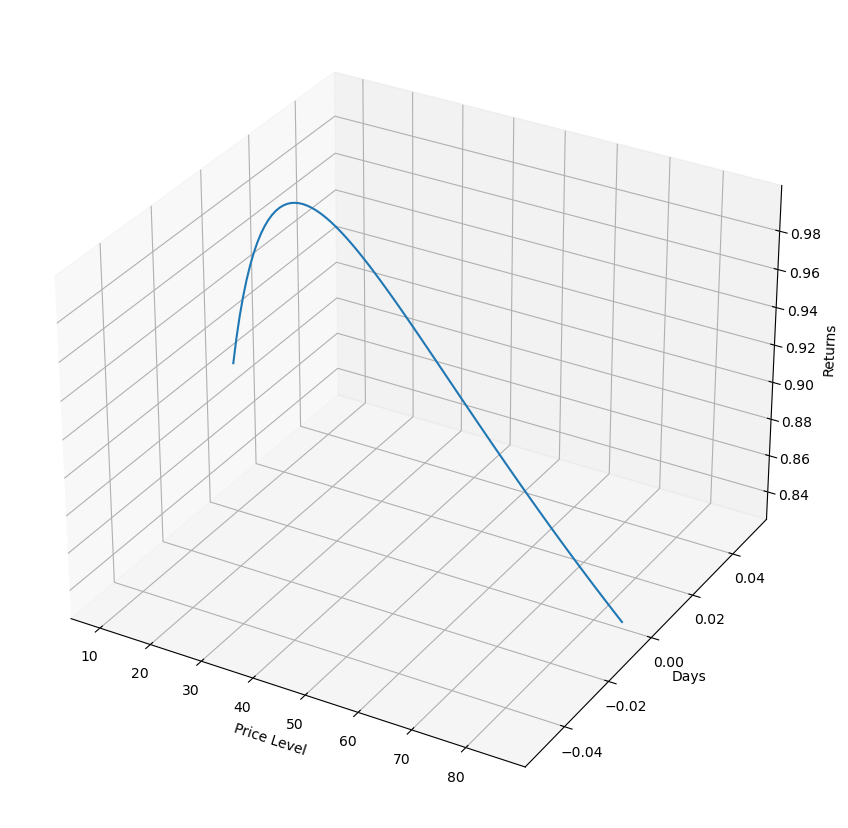

In [264]:
total = len(paths_df)+1

fig = plt.figure()
#fig, ax = plt.subplots(subplot_kw={'projection': '3d'})
fig.set_size_inches(18.5, 10.5)
ax = plt.axes(projection='3d')
#ax = fig.gca(projection='3d')

x_0, y_0 = np.mgrid[500:2000:10j, 0:95:10j]

y = 0#list(pool_performance.index)

ax.plot(IL_curve['FX'],np.full(len(IL_curve),y), IL_curve['returns'])

ax.set_xlabel('Price Level')
ax.set_ylabel('Days')
ax.set_zlabel('Returns')


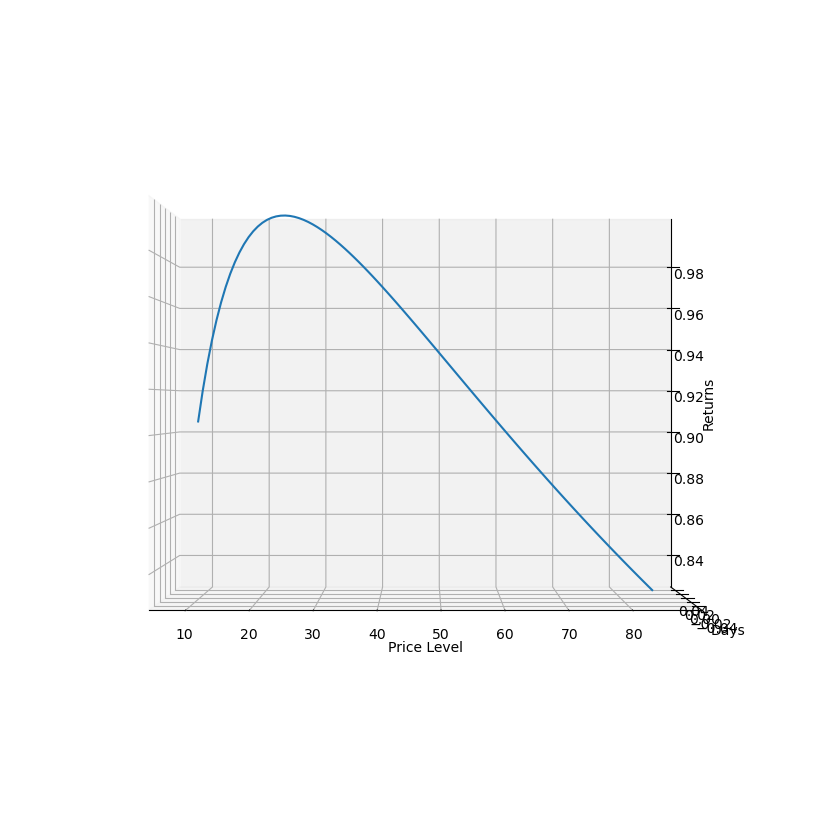

In [265]:
ax.view_init(0, 270)
fig

## IL surface

In [266]:
IL_start = IL_curve_start
IL_step = IL_curve_step
IL_end = IL_start + len(pool_performance.index) * IL_step
IL_curve = pd.DataFrame(columns=['FX', 'returns'])
IL_curve['FX'] = pd.Series(np.arange(IL_start,IL_end,IL_step))


peak = 0

In [267]:
returns = pd.Series(impermanent_loss(FX_t0, IL_curve.at[0,'FX'],relative='Y') + peak)

for i in range(1, len(IL_curve)):
    returns = pd.concat([returns, pd.Series(impermanent_loss(FX_t0, IL_curve.at[i,'FX'],relative='Y') + peak)])

IL_curve['returns'] = returns.reset_index(drop=True)+1

In [268]:
avg_return = 0.001 # statistics.mean(paths_df.iloc[0,1]['II_netto'])
average_cumprod_payoff = pd.Series((1 + np.full(len(pool_performance.index), avg_return)).cumprod())


/var/folders/jm/t_0fgqb560d3w58nyxy1qmy00000gn/T/ipykernel_50183/3290274310.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  z = z.append(IL_curve['returns'] * average_cumprod_payoff[i])
/var/folders/jm/t_0fgqb560d3w58nyxy1qmy00000gn/T/ipykernel_50183/3290274310.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  z = z.append(IL_curve['returns'] * average_cumprod_payoff[i])
/var/folders/jm/t_0fgqb560d3w58nyxy1qmy00000gn/T/ipykernel_50183/3290274310.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  z = z.append(IL_curve['returns'] * average_cumprod_payoff[i])
/var/folders/jm/t_0fgqb560d3w58nyxy1qmy00000gn/T/ipykernel_50183/3290274310.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pan

Text(0.5, 0, 'Returns')

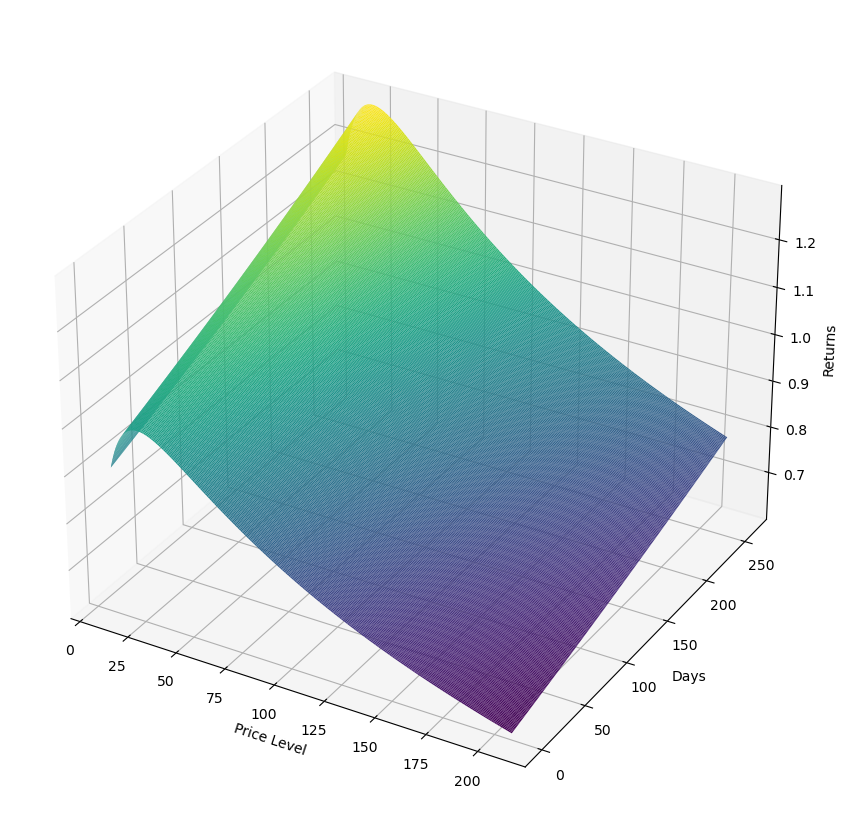

In [269]:

x, y = np.meshgrid(IL_curve['FX'], list(average_cumprod_payoff.index))
x_0, y_0 = np.mgrid[min(IL_curve['FX']):max(IL_curve['FX']):10j, 0:max(list(average_cumprod_payoff.index)):10j]

z = pd.DataFrame()
z_0 = np.ones_like(x_0)

for i in range(len(IL_curve)):
    z = z.append(IL_curve['returns'] * average_cumprod_payoff[i])


fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
ax = plt.axes(projection='3d')
ax.plot_surface(x, y, z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_xlabel('Price Level')
ax.set_ylabel('Days')
ax.set_zlabel('Returns')

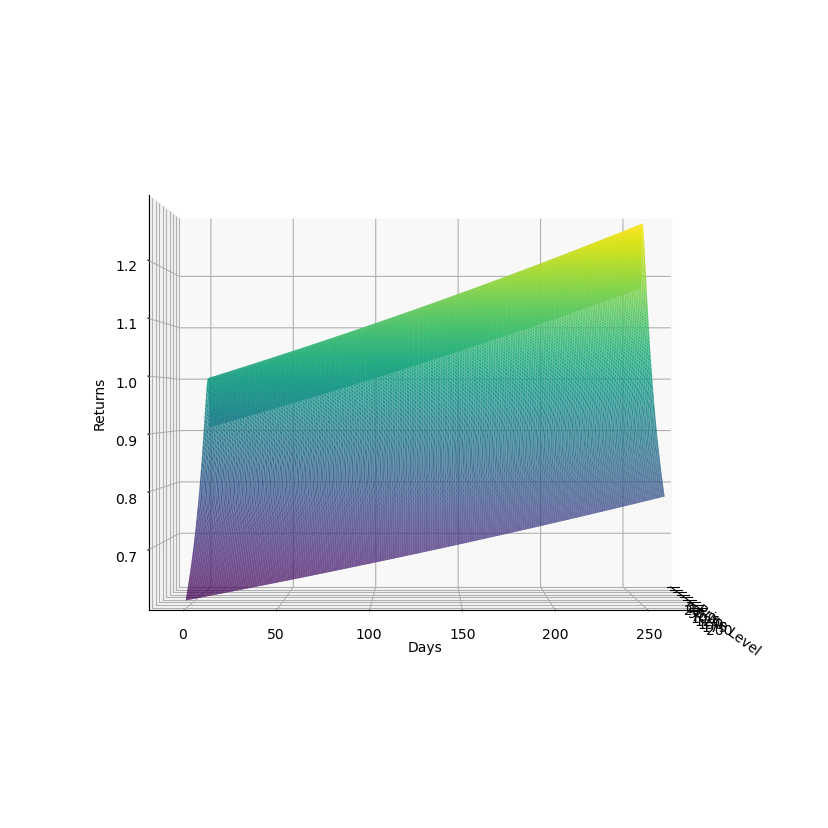

In [270]:
ax.view_init(0, 0)
fig

In [271]:
paths_df.iloc[0,1]['II_netto'] = depositor_performance['II_netto'].replace(np. nan,0)

## Payoff Paths

99%


Text(0.5, 0, 'Returns')

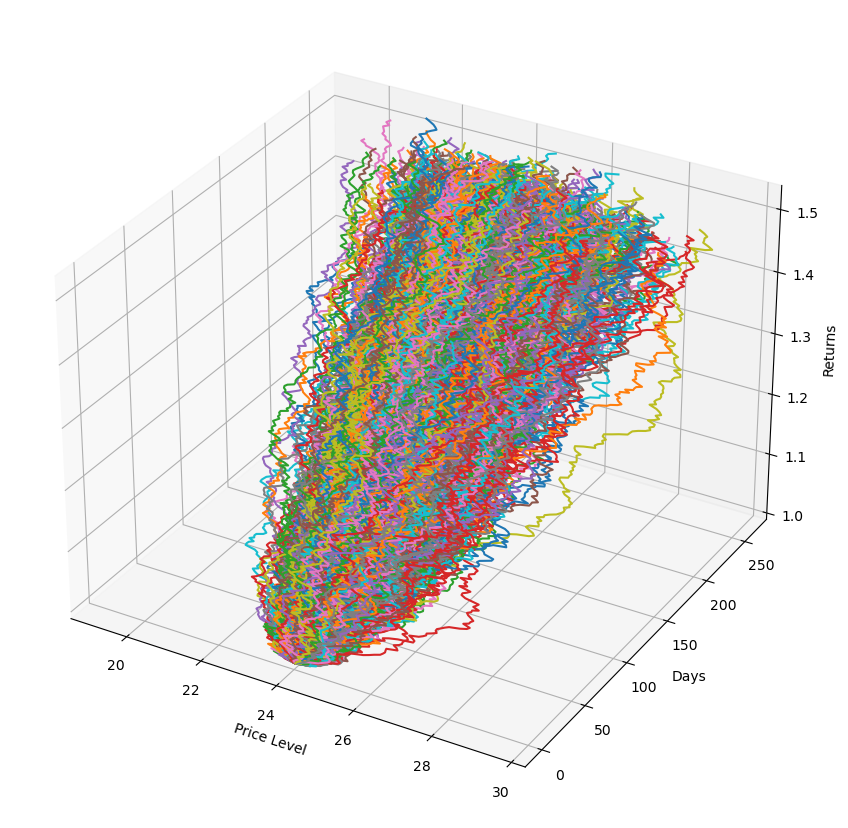

In [272]:
# Visualisation

  #x, y = np.meshgrid(pool_performance['FX'], list(pool_performance.index))

total = len(paths_df)+1

fig = plt.figure()
#fig, ax = plt.subplots(subplot_kw={'projection': '3d'})
fig.set_size_inches(18.5, 10.5)
ax = plt.axes(projection='3d')
#ax = fig.gca(projection='3d')

x_0, y_0 = np.mgrid[500:2000:10j, 0:95:10j]

y = list(pool_performance.index)

for j in range(len(paths_df)):
  #print(j)

  x = paths_df.iloc[j,1]['FX']

  z = pd.DataFrame()
  z = 1 + paths_df.iloc[j,1]['II_netto']
  #z = z.cumprod()
  z_0 = np.ones_like(x_0)

  #print(x)
  """
  for i in range(len(depositor_performance['II_netto'])):
      z = z.append(depositor_performance['II_netto'][i])
  """

  perc = ((j+1)/total)*100
  if int(perc%1) == 0:
    clear_output()
    print(str(int(perc))+'%')#, end="\n")
  #z_0 = np.zeros((len(impermanent_loss),len(impermanent_loss)))

  ax.plot3D(x, y, z)
  #ax.scatter3D(x, y, z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')

ax.set_xlabel('Price Level')
ax.set_ylabel('Days')
ax.set_zlabel('Returns')

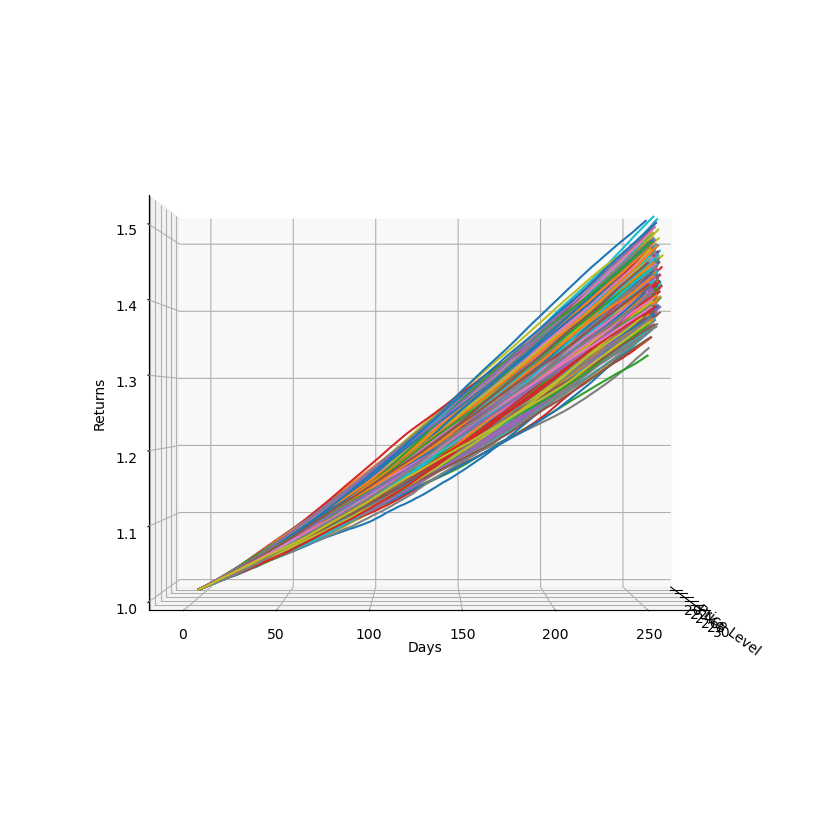

In [273]:
ax.view_init(0, 0)
fig

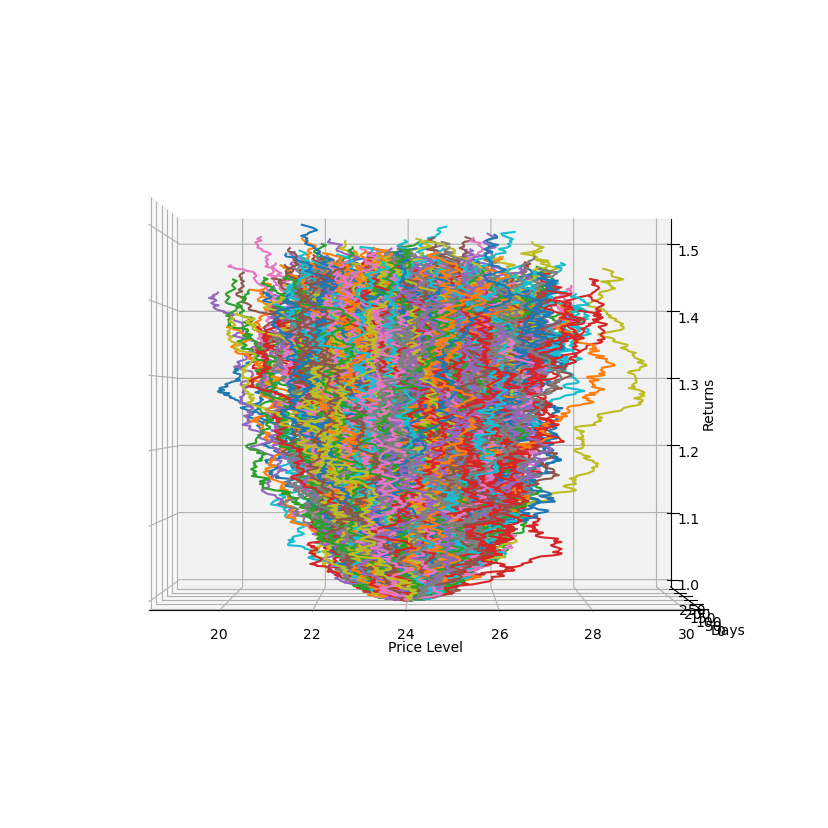

In [274]:
ax.view_init(0, 270)
fig

## Payoff Endpoints

adjust IL curve range for best visualisation

In [297]:
IL_curve_start = math.floor(min(endpoint_df['FX'])*100)/100
IL_curve_end = math.ceil(max(endpoint_df['FX'])*100)/100
IL_curve_step = (IL_curve_end - IL_curve_start)/100


In [298]:
IL_curve = pd.DataFrame(columns=['FX', 'returns'])
IL_curve['FX'] = pd.Series(np.arange(IL_curve_start,IL_curve_end,IL_curve_step))

peak_stdev = statistics.stdev(endpoint_df['cum_II_netto'])
peak_mean = statistics.mean(endpoint_df['cum_II_netto'])

peak = (peak_mean + 3*peak_stdev) #1 + max(endpoint_df['cum_II'])

In [299]:
returns = pd.Series(impermanent_loss(FX_t0, IL_curve.at[0,'FX'],relative='Y') + peak)

for i in range(1, len(IL_curve)):
    returns = pd.concat([returns, pd.Series(impermanent_loss(FX_t0, IL_curve.at[i,'FX'],relative='Y') + peak)])

IL_curve['returns'] = returns.reset_index(drop=True)

99%


Text(0.5, 0, 'Returns')

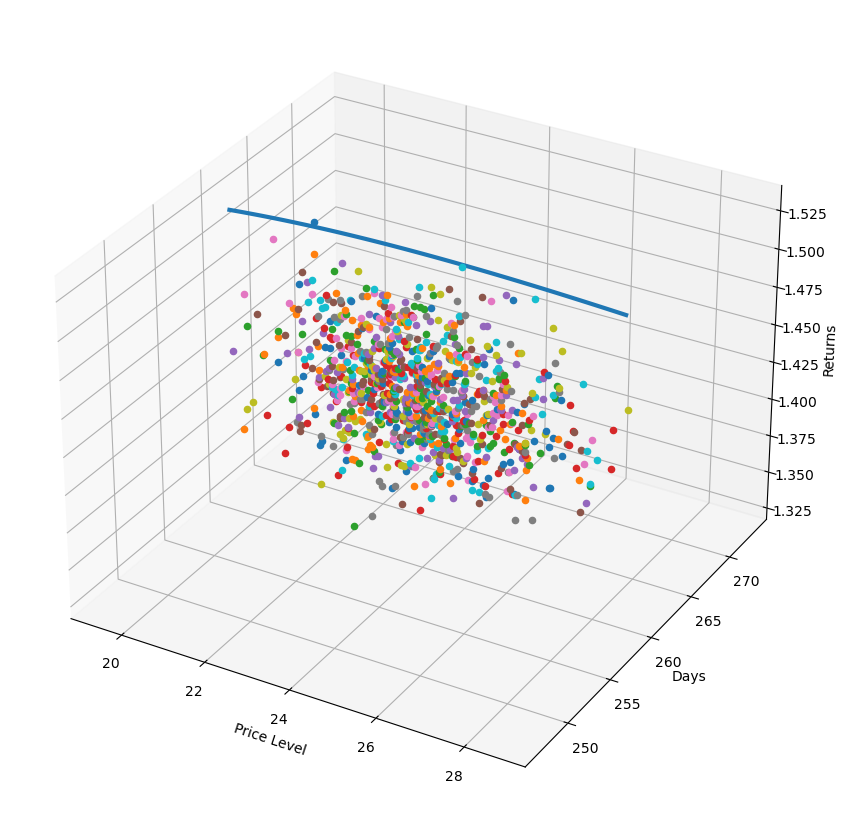

In [300]:
# Visualisation

  #x, y = np.meshgrid(pool_performance['FX'], list(pool_performance.index))

total = len(paths_df)+1

fig = plt.figure()
#fig, ax = plt.subplots(subplot_kw={'projection': '3d'})
fig.set_size_inches(18.5, 10.5)
ax = plt.axes(projection='3d')
#ax = fig.gca(projection='3d')

x_0, y_0 = np.mgrid[500:2000:10j, 0:95:10j]

y = 260#list(pool_performance.index)

for j in range(len(paths_df)):
  print(j)

  x = paths_df.iloc[j,1]['FX'][260]

  z = pd.DataFrame()
  z = 1 + paths_df.iloc[j,1]['II_netto']
  #z = z.cumprod()
  z = z[260]
  z_0 = np.ones_like(x_0)

  print(x)
  """
  for i in range(len(depositor_performance['II_netto'])):
      z = z.append(depositor_performance['II_netto'][i])
  """

  perc = ((j+1)/total)*100
  if int(perc%1) == 0:
    clear_output()
    print(str(int(perc))+'%')#, end="\n")
  #z_0 = np.zeros((len(impermanent_loss),len(impermanent_loss)))

  ax.scatter3D(x, y, z)
  #ax.scatter3D(x, y, z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')

ax.plot(IL_curve['FX'],np.full(len(IL_curve),260), IL_curve['returns'], linewidth=3)

ax.set_xlabel('Price Level')
ax.set_ylabel('Days')
ax.set_zlabel('Returns')

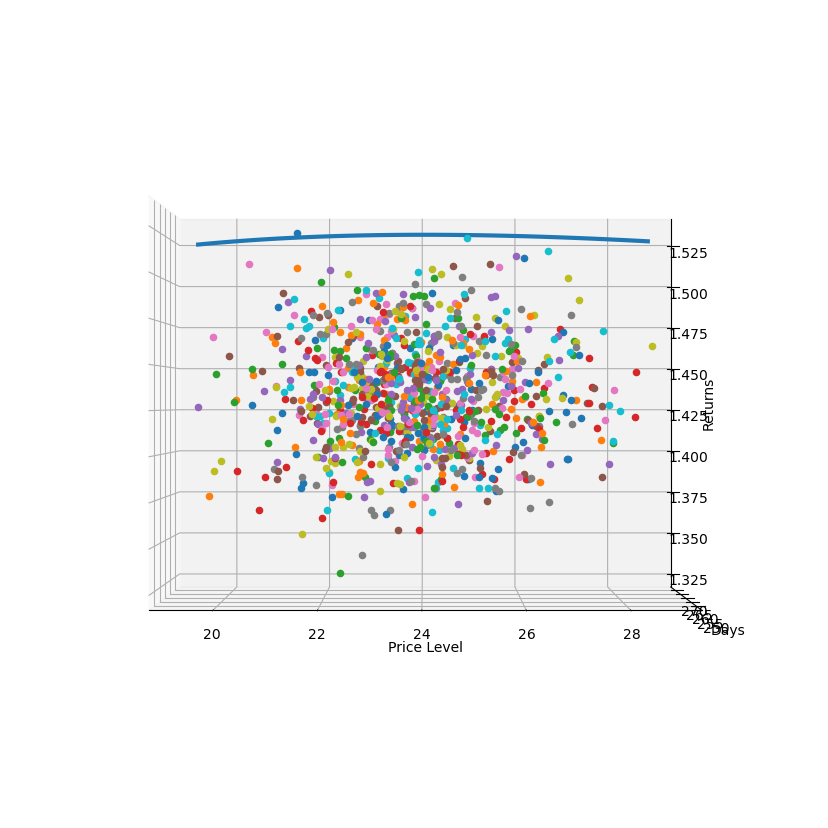

In [301]:
ax.view_init(0, 270)
#ax.set_zlim3d(1,1.05)
fig

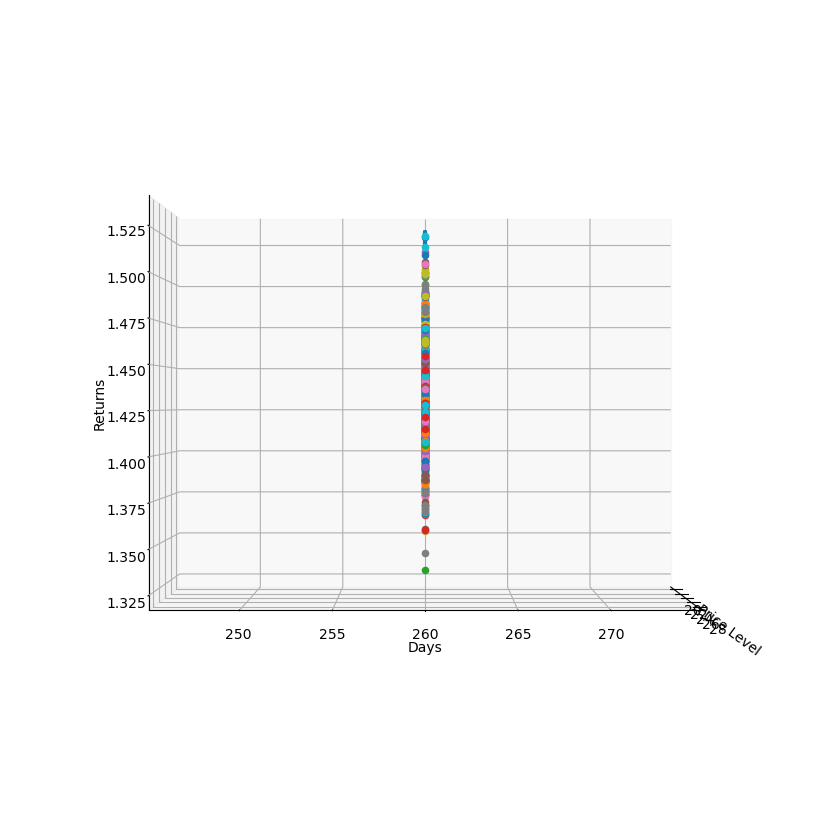

In [302]:
ax.view_init(0, 0)
fig